In [4]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Input
from keras.layers import Reshape
from keras.models import Model
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import UpSampling2D
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.preprocessing.image import load_img, img_to_array
from keras.layers.core import Flatten
from keras.optimizers import SGD
from keras.datasets import mnist
import numpy as np
from PIL import Image
import argparse
import math

from keras.applications import VGG16, vgg16
from keras import backend as K

import matplotlib.pyplot as plt

In [101]:
# def gram_matrix(x):
#     assert K.ndim(x) == 3
#     features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
#     gram = K.dot(features, K.transpose(features))
#     return gram

# def style_loss(style, combination):
#     assert K.ndim(style) == 3
#     assert K.ndim(combination) == 3
#     S = gram_matrix(style)
#     C = gram_matrix(combination)
#     channels = 3
#     size = 224*224#img_nrows * img_ncols
#     return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

def gram_matrix(x):
    assert K.ndim(x) == 3
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    assert K.ndim(style) == 3
    assert K.ndim(combination) == 3
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_nrows * img_ncols
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

# an auxiliary loss function
# designed to maintain the "content" of the
# base image in the generated image


def content_loss(base, combination):
    return K.sum(K.square(combination - base))

# the 3rd loss function, total variation loss,
# designed to keep the generated image locally coherent

def total_variation_loss(x):
    assert K.ndim(x) == 4
    a = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, 1:, :img_ncols - 1, :])
    b = K.square(x[:, :img_nrows - 1, :img_ncols - 1, :] - x[:, :img_nrows - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))



In [102]:
base_image_path = "./building.jpg"
style_reference_image_path = "./vango2.jpg"
# result_prefix = "res"
iterations = 30

total_variation_weight = 1.0
style_weight = 1.0
content_weight = 0.025 * 4 * 4

width, height = load_img(base_image_path).size
img_nrows = 224
img_ncols = 224#int(width * img_nrows / height)

In [103]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_nrows, img_ncols))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg16.preprocess_input(img)
    return img

In [104]:
# feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']

# output_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])

# # print outputs_dict

# loss = K.variable(0.)
# for layer_name in feature_layers:
#     layer_features = output_dict[layer_name]
#     combination_features = layer_features[1, :, :, :]
#     style_features = layer_features[2, :, :, :]
    
#     loss += style_loss(combination_features, style_features) / len(feature_layers)

In [158]:
def get_loss(y_true, y_pred):
#     feature_layers = ['block1_conv1', 'block2_conv1',
#                   'block3_conv1', 'block4_conv1',
#                   'block5_conv1']

#     output_dict = dict([(layer.name, layer.output) for layer in vgg_model.layers])

#     # print outputs_dict

#     loss = K.variable(0.)
#     for layer_name in feature_layers:
#         layer_features = output_dict[layer_name]
#         combination_features = layer_features[1, :, :, :]
#         style_features = layer_features[2, :, :, :]
#         loss += style_loss(combination_features, style_features) / len(feature_layers)
    print "yT", y_true
    print "yP", y_pred
    loss = style_loss(y_true[0, :, :, :], y_pred[0, :, :, :])
    print "loss", K.shape(loss), loss
    return loss

def get_actual_loss(y_true, y_pred):
    loss = K.variable(0.)
    layer_features = outputs_dict['block4_conv2']
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss += content_weight * content_loss(base_image_features,
                                          combination_features)

    feature_layers = ['block1_conv1', 'block2_conv1',
                      'block3_conv1', 'block4_conv1',
                      'block5_conv1']
    for layer_name in feature_layers:
        layer_features = outputs_dict[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        sl = style_loss(style_reference_features, combination_features)
        loss += (style_weight / len(feature_layers)) * sl
    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss


IndentationError: expected an indented block (<ipython-input-158-1b660d8ea52e>, line 22)

In [146]:
# Combine generative layer with VGG layer
inputs = Input(shape=( 224*224*3, ))
    
# Layer 1
x1 = Dense(500, activation = 'tanh', init = 'glorot_uniform')(inputs)

# Layer 2
x = Dense(16*7*7, activation = 'tanh', init = 'glorot_uniform')(x1)
x = BatchNormalization()(x)
x = Reshape((16, 7, 7))(x)

# Layer 3
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 14, 14)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 4
x = UpSampling2D(size = (2, 2))(x) #shape is (16, 28, 28)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 5
x = UpSampling2D(size = (4, 4))(x) #shape is (16, 112, 112)
x = Convolution2D(32, 5, 5, border_mode = 'same', activation = 'tanh')(x)

# Layer 6
x = UpSampling2D(size = (2, 2))(x) # 28, 28 -> 224, 224
out = Convolution2D(3, 5, 5, border_mode = 'same', activation = 'sigmoid')(x)


#  output shape is (None, 3, 224, 224)
generative_model = Model(input = inputs, output = out)

vgg_model = VGG16(weights = 'imagenet', include_top = False)
for layer in vgg_model.layers:
    layer.trainable = False
outp_vgg = vgg_model.output

# Discriminative model
disc_model = Model(input = vgg_model.input, output = vgg_model.layers[9].output)

In [147]:
model = Sequential()
model.add(generative_model)
model.add(disc_model)

In [148]:
#trainY
jpgfile = Image.open("vango2.jpg")
inp = np.array(jpgfile.getdata())
inp = np.array(jpgfile.getdata())
inp = inp.swapaxes(0, 1)
inp = np.reshape(inp, (1, 3, 224, 224))
# trainY = disc_model.predict([inp])
print inp.shape
trainY2 = disc_model.predict([inp * 1.0/256])
print trainY2.shape

# import Image
jpgfile = Image.open("building.jpg")
inp = np.array(jpgfile.getdata())
inp = inp.swapaxes(0, 1)
trainX = np.reshape(inp, (3, 224, 224))
# trainX = disc_model.predict([inp])

trainX2 = np.reshape(trainX, (1, np.product(trainX.shape)))

trainX3 = trainX2 * 1.0/256

trainX3.shape

(1, 3, 224, 224)
(1, 256, 56, 56)


(1, 150528)

In [156]:
import keras
adam_op = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
# sgd = SGD(lr=5, momentum=0.9, nesterov=True)
model.compile(loss = get_loss
              , optimizer = adam_op)

yT model_12_target
yP Elemwise{mul,no_inplace}.0
loss Shape.0 Elemwise{true_div,no_inplace}.0


In [157]:
model.fit(trainX3, trainY2, nb_epoch = 0)

In [89]:
# generative_model.compile(loss = 'mse'
#               , optimizer = adam_op)
# generative_model.fit(np.array(trainX3), np.array(inp), nb_epoch = 20)

(1, 3, 224, 224)
(1, 512, 14, 14)


(1, 150528)

In [152]:
img = generative_model.predict(trainX3)

In [153]:
img = img[0]
img = img.swapaxes(0, 2).swapaxes(0, 1)

In [154]:
print img.shape

(224, 224, 3)


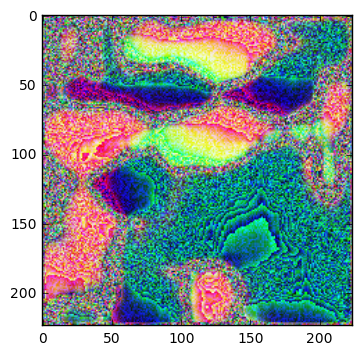

In [155]:
plt.imshow(img*256)
plt.show()

In [80]:
print trainX3

[[ 0.8046875   0.80859375  0.8046875  ...,  0.4296875   0.40234375
   0.41796875]]


In [44]:
generative_model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 150528)        0                                            
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 500)           75264500    input_3[0][0]                    
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 784)           392784      dense_3[0][0]                    
____________________________________________________________________________________________________
batchnormalization_2 (BatchNorma (None, 784)           3136        dense_4[0][0]                    
___________________________________________________________________________________________

In [48]:
print trainY2.shape, 

(1, 64, 224, 224)
